import the modules and get dataset

In [1]:
import pandas as pd
import numpy as np
import warnings
import cv2
import data
from PIL import Image
import dlib
import data_process
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")


In [2]:
x,y, a = data_process.process_data('dataset.csv', "CNN")

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
val_data = (X_test,y_test)

import keras for the model training and layers

In [3]:
from keras.layers import Activation, Convolution2D, Dropout, Conv2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.models import Model
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import SeparableConv2D
from keras import layers
from keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop

create the model with it's layers:

In [4]:
input_shape=(48, 48, 1)
num_classes = 4

model_1 = Sequential()

## 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides = (2,2), padding='same', input_shape=input_shape))
model_1.add(Activation('relu'))

## Another 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides = (2,2)))
model_1.add(Activation('relu'))

## 2x2 max pooling reduces to 3 x 3 x 32
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))

## Flatten turns 3x3x32 into 288x1
model_1.add(Flatten())
model_1.add(Dense(512))
model_1.add(Activation('relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(num_classes))
model_1.add(Activation('softmax'))

model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 32)        832       
_________________________________________________________________
activation (Activation)      (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 32)        25632     
_________________________________________________________________
activation_1 (Activation)    (None, 10, 10, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 5, 5, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0

import data generator

In [5]:
from keras.preprocessing.image import ImageDataGenerator


compile the model:

In [6]:
# data generator Generate batches of tensor image data with real-time data augmentation
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)
batch_size = 32
opt = RMSprop(lr=0.0005, decay=1e-6)

model_1.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

hist_model_1 = model_1.fit_generator(data_generator.flow(X_train, y_train,
                                            batch_size),
                        epochs=20, verbose=1,validation_data =val_data)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
11/11 [==============================] - 0s 25ms/step - loss: 1.3076 - accuracy: 0.3925 - val_loss: 1.2659 - val_accuracy: 0.5472
Epoch 2/20
11/11 [==============================] - 0s 13ms/step - loss: 1.2611 - accuracy: 0.4206 - val_loss: 1.1858 - val_accuracy: 0.4717
Epoch 3/20
11/11 [==============================] - 0s 13ms/step - loss: 1.2025 - accuracy: 0.4642 - val_loss: 1.1298 - val_accuracy: 0.5346
Epoch 4/20
11/11 [==============================] - 0s 19ms/step - loss: 1.1396 - accuracy: 0.5109 - val_loss: 1.0518 - val_accuracy: 0.5597
Epoch 5/20
11/11 [==============================] - 0s 13ms/step - loss: 1.1058 - accuracy: 0.5389 - val_loss: 0.9853 - val_accuracy: 0.5849
Epoch 6/20
11/11 [==============================] - 0s 13ms/step - loss: 0.9737 - accuracy: 0.6044 - val_loss: 0.8602 - val_accuracy: 0.6226
Epoch 7/20
11/11 [==============================] - 0s 13ms/step - loss: 0.887

Plot

5/5 [==============================] - 0s 2ms/step - loss: 0.3934 - accuracy: 0.7925


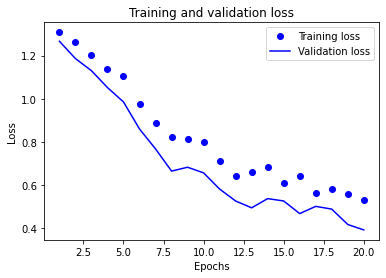

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
score = model_1.evaluate(X_test, y_test, verbose=1)
history_dict=hist_model_1.history
history_dict.keys()

train_loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.plot(epochs, train_loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

do the same with dataset2.csv

In [8]:
x2, y2, a2= data_process.process_data('dataset2.csv', "CNN")
X_train2, X_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size=0.33, random_state=42)
val_data2 = (X_test2,y_test2)


model:

In [9]:
input_shape=(48, 48, 1)
num_classes = 4

model_2 = Sequential()

## 5x5 convolution with 2x2 stride and 32 filters
model_2.add(Conv2D(32, (5, 5), strides = (2,2), padding='same', input_shape=input_shape))
model_2.add(Activation('relu'))

## Another 5x5 convolution with 2x2 stride and 32 filters
model_2.add(Conv2D(32, (5, 5), strides = (2,2)))
model_2.add(Activation('relu'))

## 2x2 max pooling reduces to 3 x 3 x 32
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))

## Flatten turns 3x3x32 into 288x1
model_2.add(Flatten())
model_2.add(Dense(512))
model_2.add(Activation('relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(num_classes))
model_2.add(Activation('softmax'))

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
activation_4 (Activation)    (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 32)        25632     
_________________________________________________________________
activation_5 (Activation)    (None, 10, 10, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)              

data generator

In [10]:
data_generator2 = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)
batch_size = 32
opt2 = RMSprop(lr=0.0005, decay=1e-6)

model_2.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

hist_model_2 = model_2.fit_generator(data_generator2.flow(X_train2, y_train2,
                                            batch_size),
                        epochs=20, verbose=1,validation_data =val_data2)

Epoch 1/20
11/11 [==============================] - 0s 22ms/step - loss: 1.2921 - accuracy: 0.3925 - val_loss: 1.1910 - val_accuracy: 0.4403
Epoch 2/20
11/11 [==============================] - 0s 12ms/step - loss: 1.2069 - accuracy: 0.4361 - val_loss: 1.1290 - val_accuracy: 0.4465
Epoch 3/20
11/11 [==============================] - 0s 13ms/step - loss: 1.1675 - accuracy: 0.4673 - val_loss: 1.0673 - val_accuracy: 0.5723
Epoch 4/20
11/11 [==============================] - 0s 14ms/step - loss: 1.1183 - accuracy: 0.4829 - val_loss: 1.0053 - val_accuracy: 0.4843
Epoch 5/20
11/11 [==============================] - 0s 13ms/step - loss: 1.0178 - accuracy: 0.5607 - val_loss: 0.8332 - val_accuracy: 0.7107
Epoch 6/20
11/11 [==============================] - 0s 13ms/step - loss: 0.9194 - accuracy: 0.6480 - val_loss: 0.7448 - val_accuracy: 0.6541
Epoch 7/20
11/11 [==============================] - 0s 12ms/step - loss: 0.8901 - accuracy: 0.6106 - val_loss: 0.6076 - val_accuracy: 0.7484
Epoch 8/20
11

plot

5/5 [==============================] - 0s 2ms/step - loss: 0.3934 - accuracy: 0.8365


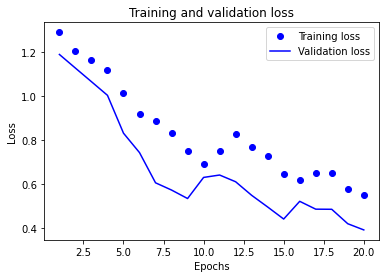

In [11]:
score2 = model_2.evaluate(X_test2, y_test2, verbose=1)
history_dict2=hist_model_2.history
history_dict2.keys()

train_loss_values2 = history_dict2['loss']
val_loss_values2 = history_dict2['val_loss']

epochs2 = range(1, len(history_dict2['accuracy']) + 1)

plt.plot(epochs2, train_loss_values2, 'bo', label='Training loss')
plt.plot(epochs2, val_loss_values2, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

compare classification metrics


In [12]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
import seaborn as sns

metrics = list()
cm = dict()
y_pred = model_1.predict(X_test)
y_pred_class = model_1.predict_classes(X_test, verbose=0)
rounded_labels = np.argmax(y_test, axis=1)

precision, recall, fscore, _ = score(rounded_labels, y_pred_class, average='weighted')
accuracy = accuracy_score(rounded_labels, y_pred_class)
auc = roc_auc_score(y_test, y_pred)
metrics.append(pd.Series({'precision':precision, 'recall':recall, 'fscore':fscore, 'accuracy':accuracy, 'auc':auc}, name="model1"))
cm = confusion_matrix(rounded_labels,y_pred_class)

metrics2 = list()
cm2 = dict()
y_pred2 = model_2.predict(X_test2)
y_pred_class2 = model_2.predict_classes(X_test2, verbose=0)
rounded_labels2 = np.argmax(y_test2, axis=1)

precision2, recall2, fscore2, _ = score(rounded_labels2, y_pred_class2, average='weighted')
accuracy2 = accuracy_score(rounded_labels2, y_pred_class2)
auc2 = roc_auc_score(y_test2, y_pred2)
metrics2.append(pd.Series({'precision':precision2, 'recall':recall2, 'fscore':fscore2, 'accuracy':accuracy2, 'auc':auc2}, name="model2"))
cm2 = confusion_matrix(rounded_labels2,y_pred_class2)
m = metrics + metrics2
metrics = pd.concat(m, axis=1)

metrics


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


ValueError: Shape of passed values is (159, 1), indices imply (159, 4)

In [ ]:

def get_unique_N(iterable):
    seen = set()
    for e in iterable:
        if e in seen:
            continue
        seen.add(e)
        yield e

k = get_unique_N(a)
print(list(k))

In [ ]:
ax = sns.heatmap(cm, annot=True, fmt='d')

In [ ]:
k2 = get_unique_N(a2)
print(list(k2))

In [ ]:
ax2 = sns.heatmap(cm2, annot=True, fmt='d')
